<i>Ahamed Arafaath Muthalif Mubarak Ali</i>

# Homework 2

Using what you learned today, design a MLP model to train the Fashion MNIST data for the best accuracy in test. You can use either sequential API or functional API. Describe how you come to your choice of hyperparameters. What’s the best result you can achieve?

Submission: a Jupyter notebook file with all your intermediate investigations, explanations, and results.


# Fine-tuning NN Hyperparameters
* number of layers
* number of neurons per layer
* type of activation function in each layer
* optimizer selection
* learning rate
* batch size
* cost function selection
* weight initialization logic
...

### <u>Packages Import</u>

In [112]:
import tensorflow as tf
from tensorflow import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

#grid search
from keras.optimizers import *
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import pprint
pp = pprint.PrettyPrinter(indent = 4)

### <u>Save_fig function from W2 lecture notes</u>

In [30]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "W2hw2"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "HW2", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### <u>Load and explore the dataset</u>

In [10]:
fashion_mnist = fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [11]:
#Normalize the dataset
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

In [13]:
X_train.shape

(55000, 28, 28)

In [14]:
X_test.shape

(10000, 28, 28)

In [16]:
X_train_full[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
          0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
          0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
         10,   0],
       [  

In [17]:
X_train[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00392157,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.17254902, 0.49803922, 0.71372549, 0.7254902 ,
        0.63137255, 0.47058824, 0.21568627, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.16470588,
        0.77647059, 0.98431373, 1.        , 0.98431373, 0.97647059,
        0.96862745, 1.    

In [23]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

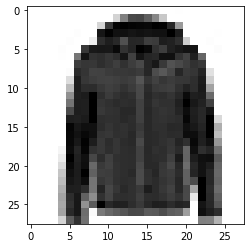

In [24]:
plt.imshow(X_train[0], cmap="binary")
plt.show()

Saving figure fashion_mnist_plot


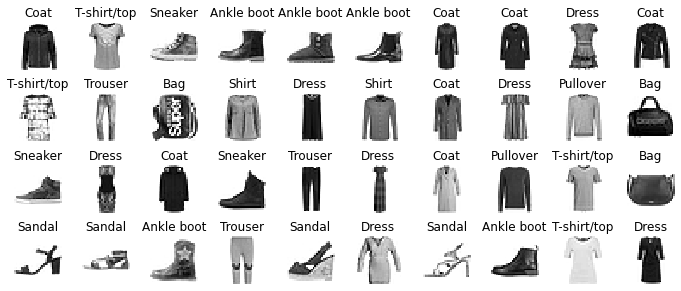

In [31]:
#Visualizing the dataset and storing in the local device
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

In [35]:
# Clear the memory
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

### <u>Model building and compiling</u>

In [37]:
# building a pyramid scheme neural network
model = Sequential([
    Flatten(input_shape=[28, 28]),
    Dense(512, activation="relu"),
    Dense(300, activation="relu"),
    Dense(100, activation="relu"),
    Dense(10, activation="softmax")
])

2022-02-04 19:12:00.503064: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 300)               153900    
                                                                 
 dense_2 (Dense)             (None, 100)               30100     
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
Total params: 586,930
Trainable params: 586,930
Non-trainable params: 0
_________________________________________________________________


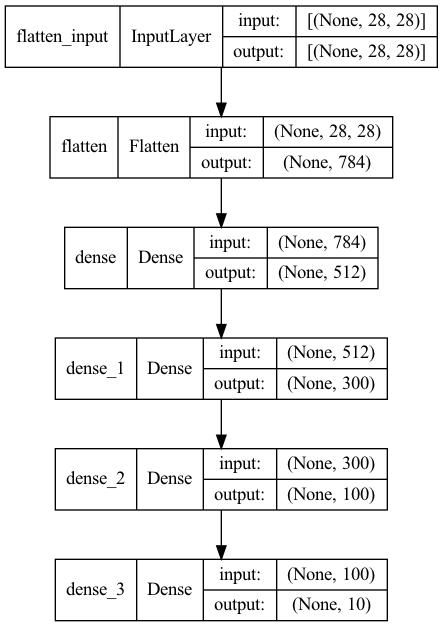

In [39]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [40]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [58]:
hidden2 = model.layers[3]
hidden2.name

'dense_2'

In [41]:
model.get_layer(hidden1.name) is hidden1 # use name to get layer

True

In [42]:
weights, biases = hidden1.get_weights()

In [43]:
weights.shape

(784, 512)

In [44]:
biases.shape

(512,)

In [45]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])

In [46]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 15s 8ms/step - loss: 0.7166 - sparse_categorical_accuracy: 0.7623 - val_loss: 0.5173 - val_sparse_categorical_accuracy: 0.8226
Epoch 2/30
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4721 - sparse_categorical_accuracy: 0.8340 - val_loss: 0.4141 - val_sparse_categorical_accuracy: 0.8550
Epoch 3/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4221 - sparse_categorical_accuracy: 0.8500 - val_loss: 0.5317 - val_sparse_categorical_accuracy: 0.8018
Epoch 4/30
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3937 - sparse_categorical_accuracy: 0.8614 - val_loss: 0.3728 - val_sparse_categorical_accuracy: 0.8710
Epoch 5/30
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3737 - sparse_categorical_accuracy: 0.8684 - val_loss: 0.3527 - val_sparse_categorical_accuracy: 0.8732
Epoch 6/30
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3532 - spa

In [47]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [48]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


Saving figure keras_learning_curves_plot


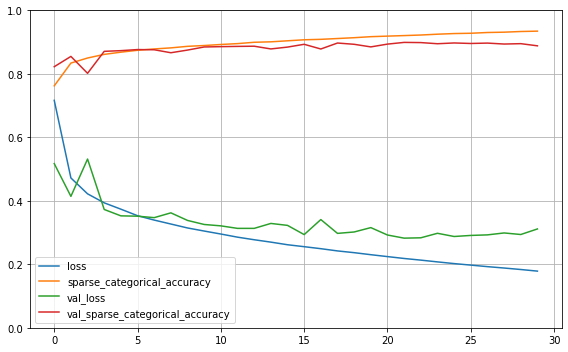

In [49]:
# Learning curve
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [50]:
score = model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.3476 - sparse_categorical_accuracy: 0.8815


In [51]:
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.34759044647216797
Test accuracy: 0.8815000057220459


### <u>Prediction for model 1</u>

In [52]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99],
       [0.  , 0.  , 0.97, 0.  , 0.03, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [53]:
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

array([9, 2, 1])

Saving figure fashion_mnist_images_plot


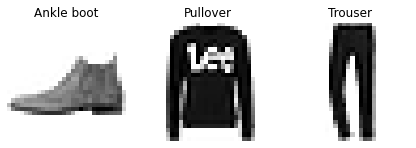

In [54]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

Since this model training gave an accuracy of 88% on the test datase, now let's try to tune the model by using adding another layer with 300 neurons and relu as activation function.

This time let's use keras weights and bias initializer

### <u>Model building and training 2</u>

In [55]:
# Clear the memory
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [56]:
# building a pyramid scheme neural network
model = Sequential([
    Flatten(input_shape=[28, 28]),
    Dense(512, activation="relu", kernel_initializer='random_normal', bias_initializer='zeros'),
    Dense(300, activation="relu"),
    Dense(300, activation="relu"),
    Dense(100, activation="relu"),
    Dense(10, activation="softmax")
])

In [57]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 300)               153900    
                                                                 
 dense_2 (Dense)             (None, 300)               90300     
                                                                 
 dense_3 (Dense)             (None, 100)               30100     
                                                                 
 dense_4 (Dense)             (None, 10)                1010      
                                                                 
Total params: 677,230
Trainable params: 677,230
Non-trai

In [59]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [60]:
history_2 = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 12s 6ms/step - loss: 0.7120 - accuracy: 0.7621 - val_loss: 0.5291 - val_accuracy: 0.8126
Epoch 2/30
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4625 - accuracy: 0.8360 - val_loss: 0.4021 - val_accuracy: 0.8566
Epoch 3/30
1719/1719 [==============================] - 17s 10ms/step - loss: 0.4094 - accuracy: 0.8524 - val_loss: 0.5355 - val_accuracy: 0.7984
Epoch 4/30
1719/1719 [==============================] - 11s 7ms/step - loss: 0.3790 - accuracy: 0.8648 - val_loss: 0.3592 - val_accuracy: 0.8708
Epoch 5/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3574 - accuracy: 0.8714 - val_loss: 0.3459 - val_accuracy: 0.8736
Epoch 6/30
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3369 - accuracy: 0.8765 - val_loss: 0.3437 - val_accuracy: 0.8794
Epoch 7/30
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3230 - accuracy: 0.8823 - val_loss: 0.3380 - val_ac

Saving figure keras_learning_curves_plot


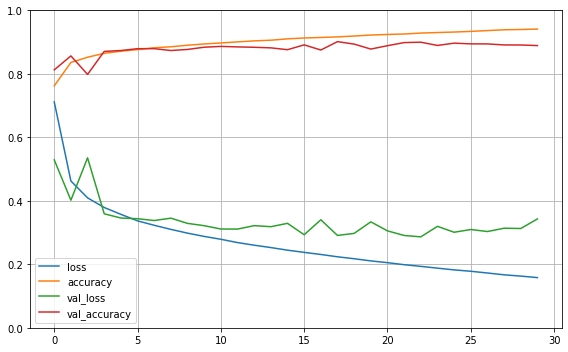

In [61]:
# Learning curve
pd.DataFrame(history_2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [62]:
score_2 = model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.3641 - accuracy: 0.8806


In [64]:
print('Test loss:', score_2[0]) 
print('Test accuracy:', score_2[1])

Test loss: 0.3640640676021576
Test accuracy: 0.8805999755859375


Accuracy of this model is lesser than the initial model althought it is a smaller difference but still less, the goal was to boost the accuracy, so now let's try having the same number of neurons i.e., 512 in all the hidden layers

### <u>Model building and evaluating 3</u>

In [65]:
# Clear the memory
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [66]:
# building a neural network
model = Sequential([
    Flatten(input_shape=[28, 28]),
    Dense(512, activation="relu"),
    Dense(512, activation="relu"),
    Dense(512, activation="relu"),
    Dense(512, activation="relu"),
    Dense(10, activation="softmax")
])

In [67]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dense_4 (Dense)             (None, 10)                5130      
                                                                 
Total params: 1,195,018
Trainable params: 1,195,018
Non-

This time let's try with a learning rate of 0.01

In [68]:
optim = keras.optimizers.SGD(lr=0.01)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optim,
              metrics=["accuracy"])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [69]:
history_3 = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 22s 12ms/step - loss: 0.7310 - accuracy: 0.7532 - val_loss: 0.5519 - val_accuracy: 0.8080
Epoch 2/30
1719/1719 [==============================] - 18s 11ms/step - loss: 0.4649 - accuracy: 0.8347 - val_loss: 0.4032 - val_accuracy: 0.8630
Epoch 3/30
1719/1719 [==============================] - 23s 13ms/step - loss: 0.4107 - accuracy: 0.8526 - val_loss: 0.5618 - val_accuracy: 0.7906
Epoch 4/30
1719/1719 [==============================] - 24s 14ms/step - loss: 0.3795 - accuracy: 0.8645 - val_loss: 0.3588 - val_accuracy: 0.8760
Epoch 5/30
1719/1719 [==============================] - 27s 16ms/step - loss: 0.3581 - accuracy: 0.8720 - val_loss: 0.3438 - val_accuracy: 0.8748
Epoch 6/30
1719/1719 [==============================] - 25s 15ms/step - loss: 0.3376 - accuracy: 0.8775 - val_loss: 0.3409 - val_accuracy: 0.8778
Epoch 7/30
1719/1719 [==============================] - 26s 15ms/step - loss: 0.3238 - accuracy: 0.8826 - val_loss: 0.3463 -

Saving figure keras_learning_curves_plot


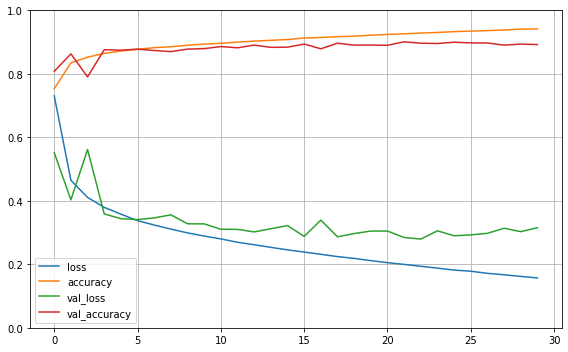

In [89]:
# Learning curve
pd.DataFrame(history_3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [71]:
score_3 = model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.3517 - accuracy: 0.8831


In [72]:
print('Test loss:', score_3[0]) 
print('Test accuracy:', score_3[1])

Test loss: 0.3517085015773773
Test accuracy: 0.8830999732017517


Okay now this is an improvement, let's use a different activation say tanh this time (hopefully we don't face the vanishing gradients problem)

### <u>Model training and evaluation</u>

In [74]:
# Clear the memory
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [75]:
# building a neural network
model = Sequential([
    Flatten(input_shape=[28, 28]),
    Dense(512, activation="tanh"),
    Dense(512, activation="tanh"),
    Dense(512, activation="tanh"),
    Dense(512, activation="tanh"),
    Dense(10, activation="softmax")
])

In [76]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dense_4 (Dense)             (None, 10)                5130      
                                                                 
Total params: 1,195,018
Trainable params: 1,195,018
Non-

In [77]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optim = keras.optimizers.SGD(learning_rate=lr_schedule)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optim,
              metrics=["accuracy"])
#Source - https://keras.io/api/optimizers/

In [78]:
history_4 = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 18s 10ms/step - loss: 0.5871 - accuracy: 0.7961 - val_loss: 0.4646 - val_accuracy: 0.8364
Epoch 2/30
1719/1719 [==============================] - 14s 8ms/step - loss: 0.4400 - accuracy: 0.8415 - val_loss: 0.4014 - val_accuracy: 0.8618
Epoch 3/30
1719/1719 [==============================] - 15s 9ms/step - loss: 0.4088 - accuracy: 0.8520 - val_loss: 0.4955 - val_accuracy: 0.8056
Epoch 4/30
1719/1719 [==============================] - 22s 13ms/step - loss: 0.3888 - accuracy: 0.8604 - val_loss: 0.3759 - val_accuracy: 0.8678
Epoch 5/30
1719/1719 [==============================] - 18s 11ms/step - loss: 0.3752 - accuracy: 0.8648 - val_loss: 0.3680 - val_accuracy: 0.8680
Epoch 6/30
1719/1719 [==============================] - 18s 11ms/step - loss: 0.3605 - accuracy: 0.8702 - val_loss: 0.3585 - val_accuracy: 0.8748
Epoch 7/30
1719/1719 [==============================] - 19s 11ms/step - loss: 0.3508 - accuracy: 0.8737 - val_loss: 0.3618 - v

Saving figure keras_learning_curves_plot


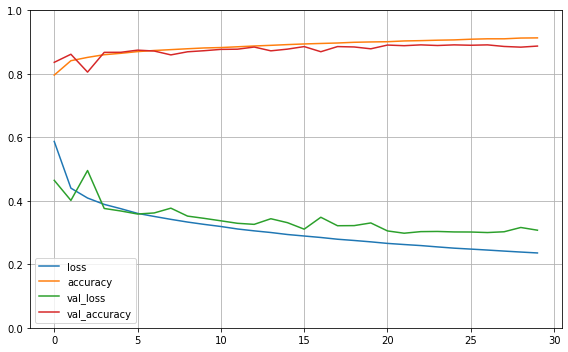

In [90]:
# Learning curve
pd.DataFrame(history_4.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [81]:
score_4 = model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.3414 - accuracy: 0.8793


In [82]:
print('Test loss:', score_4[0]) 
print('Test accuracy:', score_4[1])

Test loss: 0.34142592549324036
Test accuracy: 0.8792999982833862


Okay using tanh was not useful, now going back to relu and this time let's try adam optimizer based on the google search it seems like adam optimizer is the best to train a neural network, so let's test that hypothesis.

### <u>Model Training and evaluation 5</u>

In [83]:
# Clear the memory
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [84]:
# building a neural network with dropout layers
model = Sequential([
    Flatten(input_shape=[28, 28]),
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(10, activation="softmax")
])
# Source - https://towardsdatascience.com/machine-learning-part-20-dropout-keras-layers-explained-8c9f6dc4c9ab#:~:text=Dropout%20is%20a%20technique%20used,update%20of%20the%20training%20phase.

In [85]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0

In [97]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])

In [99]:
history_5 = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 21s 12ms/step - loss: 1.9395 - accuracy: 0.2439 - val_loss: 1.7922 - val_accuracy: 0.2800
Epoch 2/30
1719/1719 [==============================] - 22s 13ms/step - loss: 1.9283 - accuracy: 0.2475 - val_loss: 1.8016 - val_accuracy: 0.2846
Epoch 3/30
1719/1719 [==============================] - 19s 11ms/step - loss: 1.9209 - accuracy: 0.2512 - val_loss: 1.7613 - val_accuracy: 0.2890
Epoch 4/30
1719/1719 [==============================] - 21s 12ms/step - loss: 1.9086 - accuracy: 0.2549 - val_loss: 1.8729 - val_accuracy: 0.2778
Epoch 5/30
1719/1719 [==============================] - 24s 14ms/step - loss: 1.9057 - accuracy: 0.2577 - val_loss: 1.7791 - val_accuracy: 0.2912
Epoch 6/30
1719/1719 [==============================] - 24s 14ms/step - loss: 1.8996 - accuracy: 0.2566 - val_loss: 1.8583 - val_accuracy: 0.2826
Epoch 7/30
1719/1719 [==============================] - 26s 15ms/step - loss: 1.9032 - accuracy: 0.2572 - val_loss: 1.8622 -

Saving figure keras_learning_curves_plot


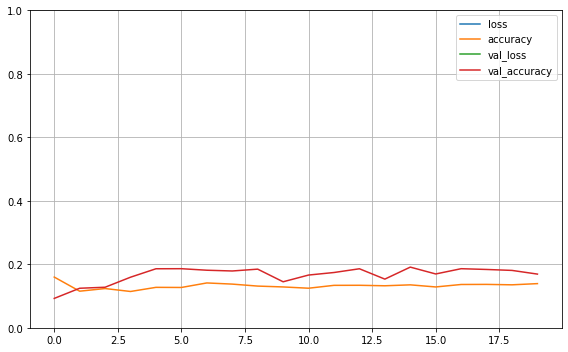

In [91]:
# Learning curve
pd.DataFrame(history_5.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [92]:
score_4 = model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 2.1330 - accuracy: 0.1649


In [93]:
print('Test loss:', score_4[0]) 
print('Test accuracy:', score_4[1])

Test loss: 2.1329574584960938
Test accuracy: 0.164900004863739


Well the google search turned out to be wrong and the model performed worse here, perhaps adam works better on the regression problem, need to read more about this. Next let's do grid search and see how the output is

### <u>Grid search on the best output model</u>

In [102]:
# Clear the memory
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

Source - https://www.kaggle.com/jserna/hyperparameters-optimization-on-fashion-mnist

In [103]:
#def build_model(n_hidden=4, nu_neuron=512, learning_rate=3e-3, input_shape=[28, 28])
def build_model(optimizer, learning_rate, activation, dropout_rate,
                initializer,num_unit):
    model = Sequential()
    model.add(Flatten(input_shape=(28,28)))
    
    model.add(Dense(num_unit, kernel_initializer=initializer,
                    activation=activation))
    model.add(Dropout(dropout_rate)) 
    
    model.add(Dense(num_unit, kernel_initializer=initializer,
                    activation=activation))
    model.add(Dropout(dropout_rate)) 
    
    model.add(Dense(num_unit, kernel_initializer=initializer,
                    activation=activation))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(num_unit, kernel_initializer=initializer,
                    activation=activation))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer(lr=learning_rate),
                  metrics=['accuracy'])
    return model

In [110]:
# [:1] is for testing

batch_size = [30, 50, 100][:1]

epochs = [1, 20, 50][:1]

initializer = ['lecun_uniform', 'normal', 'he_normal', 'he_uniform'][:1]

learning_rate = [0.1, 0.001, 0.02][:1]

dropout_rate = [0.3, 0.2, 0.8][:1]

num_unit = [512, 300, 100][:1]

activation = ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'][:1]

optimizer = [keras.optimizers.SGD, keras.optimizers.RMSprop, keras.optimizers.Adagrad, 
             keras.optimizers.Adadelta, keras.optimizers.Adam, keras.optimizers.Adamax, 
             keras.optimizers.Nadam][:1]

In [111]:
# Creat the wrapper and pass params to GridSearchCV 
# parameters is a dict with all values

parameters = dict(batch_size = batch_size,
                  epochs = epochs,
                  dropout_rate = dropout_rate,
                  num_unit = num_unit,
                  initializer = initializer,
                  learning_rate = learning_rate,
                  activation = activation,
                  optimizer = optimizer)

model = KerasClassifier(build_fn=build_model, verbose=0)

models = GridSearchCV(estimator = model, param_grid=parameters, n_jobs=1)

/var/folders/kr/gtcybxvj34v71bp1q0gc41ww0000gn/T/ipykernel_55894/721556897.py:13: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model = KerasClassifier(build_fn=build_model, verbose=0)


In [114]:
best_model = models.fit(X_train, y_train)
print('Best model :')
pp.pprint(best_model.best_params_)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/Library/Frameworks/Python.framework

Best model :
{   'activation': 'relu',
    'batch_size': 30,
    'dropout_rate': 0.3,
    'epochs': 1,
    'initializer': 'lecun_uniform',
    'learning_rate': 0.1,
    'num_unit': 512,
    'optimizer': <class 'keras.optimizer_v2.gradient_descent.SGD'>}


In [119]:
grid_Search_model = best_model.best_estimator_

In [120]:
history_6 = grid_Search_model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Saving figure keras_learning_curves_plot


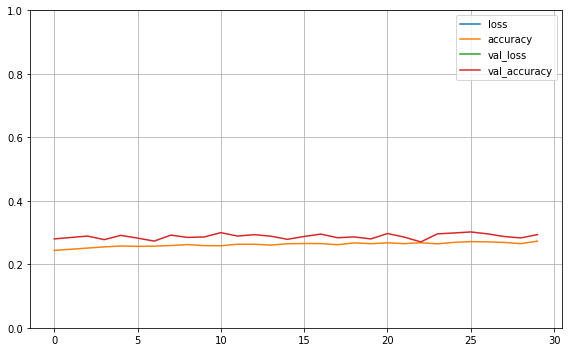

In [121]:
# Learning curve
pd.DataFrame(history_5.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

Something seems to be wrong with the grid search, I must have messed up somewhere, I need to do more research on this. Now let's give one last try with different layers.

In [123]:
# Clear the memory
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [124]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=0.1),
              metrics=["accuracy"])
history_6 = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))


Epoch 1/30
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5515 - accuracy: 0.7976 - val_loss: 0.5519 - val_accuracy: 0.7954
Epoch 2/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3921 - accuracy: 0.8549 - val_loss: 0.3408 - val_accuracy: 0.8772
Epoch 3/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3505 - accuracy: 0.8681 - val_loss: 0.5247 - val_accuracy: 0.8050
Epoch 4/30
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3256 - accuracy: 0.8771 - val_loss: 0.3394 - val_accuracy: 0.8722
Epoch 5/30
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3086 - accuracy: 0.8846 - val_loss: 0.3303 - val_accuracy: 0.8782
Epoch 6/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2896 - accuracy: 0.8919 - val_loss: 0.3146 - val_accuracy: 0.8848
Epoch 7/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2767 - accuracy: 0.8954 - val_loss: 0.3294 - val_accuracy

In [143]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 300)               235500    
                                                                 
 dense_5 (Dense)             (None, 100)               30100     
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 10)                1010      
                                                                 
Total params: 276,710
Trainable params: 276,710
Non-trainable params: 0
_________________________________________________________________


Saving figure keras_learning_curves_plot


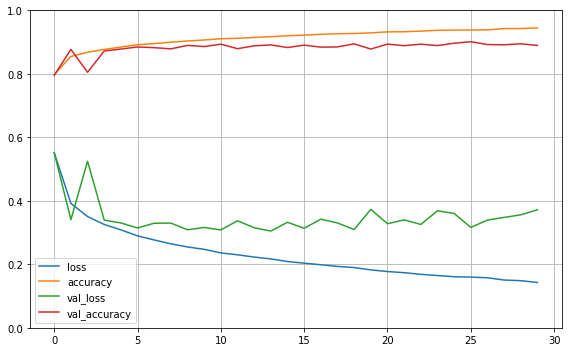

In [125]:
# Learning curve
pd.DataFrame(history_6.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [126]:
score_6 = model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.4091 - accuracy: 0.8843


In [127]:
print('Test loss:', score_6[0]) 
print('Test accuracy:', score_6[1])

Test loss: 0.4091496467590332
Test accuracy: 0.8842999935150146


### So far the best accuracy we acheived was 88.42% after trying mulitple steps for hyperparameter tuning. 

So far, we tried tweaking the layers, neurons, activation functions, optimizer, learning rate, batch size and grid search.